In [1]:
import os
import h2o
import pandas as pd
import numpy as np
import datetime as dt
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
pd_train = (pd.read_csv('../data/train.csv', na_values=999)
           .fillna(value=999))
            
pd_test  = (pd.read_csv('../data/test.csv', na_values=999)
           .fillna(value=999)) 
pd_targets = pd_train.target.values


In [6]:
pd_test_id = pd_test.id.values
pd_test = pd_test.drop('id', axis=1)

In [65]:
only_col= testh2o_df['ps_reg_03'].as_data_frame(True)

In [70]:
only_col[only_col==-1] = np.mean(only_col).values[0]

In [71]:
np.mean(only_col).values[0]

0.83275160037282103

In [63]:
np.mean(testh2o_df['ps_reg_03'].as_data_frame(True)).values[0]

0.55174011649155985

In [81]:
def cut_column(train_df, train, test, col):
    '''
    Convenience function to change a column from numerical to categorical
    We use train_df only for bucketing with histograms.
    Uses np.histogram to generate a histogram, with the buckets forming the categories of our new categorical.
    Picks buckets based on training data, then applies the same classification to the test and validation sets
    
    Assumes that train, valid, test will have the same histogram behavior.
    '''
    only_col= train_df[col]                         #Isolate the column in question from the training frame
    only_col[only_col==-1] = np.mean(only_col)
    counts, breaks = np.histogram(only_col, bins=20)   #Generate counts and breaks for our histogram
    min_val = min(only_col)-1                          #Establish min and max values
    max_val = max(only_col)+1
    
    new_b = [float(min_val)]                                  #Redefine breaks such that each bucket has enough support
    for i in range(19):
        if counts[i] > 1000 and counts[i+1] > 1000:
            new_b.append(breaks[i+1])
    new_b.append(float(max_val))
    
    names = [col + '_' + str(x) for x in range(len(new_b)-1)]  #Generate names for buckets, these will be categorical names
    
    train[col+"_cut"] = train[col].cut(breaks=new_b, labels=names)
    test[col+"_cut"]  = test[col].cut(breaks=new_b, labels=names)

In [50]:
def add_features(train, test):
    '''
    Helper function to add a specific set of features to our covertype dataset
    '''
    #pull train dataset into Python
    train_df = train.as_data_frame(True)
    
    #Make categoricals for several columns
    cut_column(train_df, train, test, "ps_car_13")
    cut_column(train_df, train, test, "ps_ind_03")
    cut_column(train_df, train, test, "ps_reg_03")
    cut_column(train_df, train, test, "ps_reg_02")
    
    
    #Add interaction columns for a subset of columns
    interaction_cols1 = ['ps_car_11_cat',
                         'ps_ind_05_cat',
                         'ps_car_13_cut',
                         'ps_ind_17_bin',
                         'ps_car_01_cat',
                         'ps_ind_03_cut',
                         'ps_car_07_cat',
                         'ps_reg_03_cut',
                         'ps_car_06_cat',
                         'ps_reg_02_cut']

    train_cols = train.interaction(factors=interaction_cols1,    #Generate pairwise columns
                                   pairwise=True,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="itrain")

    test_cols = test.interaction(factors=interaction_cols1,
                                   pairwise=True,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="itest")
    
    train = train.cbind(train_cols)                              #Append pairwise columns to H2OFrames
    test = test.cbind(test_cols)
    
    
    #Add a three-way interaction for Hillshade
    interaction_cols2 = ['ps_car_11_cat',
                         'ps_ind_05_cat',
                         'ps_car_13_cut']
    
    train_cols = train.interaction(factors=interaction_cols2,    #Generate pairwise columns
                                   pairwise=False,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="itrain")

    test_cols = test.interaction(factors=interaction_cols2,
                                   pairwise=False,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="itest")
    
    train = train.cbind(train_cols)                              #Append pairwise columns to H2OFrames
    test = test.cbind(test_cols)
    
    #Add a three-way interaction for Hillshade
    interaction_cols3 = ['ps_car_11_cat',
                         'ps_car_01_cat',
                         'ps_reg_02_cut']
    
    train_cols = train.interaction(factors=interaction_cols3,    #Generate pairwise columns
                                   pairwise=False,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="itrain")

    test_cols = test.interaction(factors=interaction_cols3,
                                   pairwise=False,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="itest")
    
    train = train.cbind(train_cols)                              #Append pairwise columns to H2OFrames
    test = test.cbind(test_cols)
    
    #Add a three-way interaction for Hillshade
    interaction_cols4 = ['ps_car_01_cat',
                         'ps_ind_05_cat']
    
    train_cols = train.interaction(factors=interaction_cols4,    #Generate pairwise columns
                                   pairwise=False,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="itrain")

    test_cols = test.interaction(factors=interaction_cols4,
                                   pairwise=False,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="itest")
    
    train = train.cbind(train_cols)                              #Append pairwise columns to H2OFrames
    test = test.cbind(test_cols)
    
    return train, test

In [9]:
def make_dicts(df):
    f_dicts ={}
    
    features_dict = {}
    for x in ['ind', 'reg', 'car', 'calc']:
        for y in ['cat', 'bin', 'con']:
            features_dict[x+'_'+y] =[]
            for i in df.columns.tolist()[2:]:
                j = i.split('_')
                if len(j) == 3:
                    j.append('con')
                if j[1]==x and j[3]==y:
                    features_dict[x+'_'+y].append(i)
    f_dicts['combo'] = features_dict
    
    features_dict_data_type = {}
    for y in ['cat', 'bin', 'con']:
        features_dict_data_type[y]=[]
        for i in df.columns.tolist()[2:]:
            j = i.split('_')
            if len(j) == 3:
                j.append('con')
            if j[3]==y:
                features_dict_data_type[y].append(i)
    f_dicts['type'] = features_dict_data_type
    
    features_dict_data_label = {}
    for x in ['ind', 'reg', 'car', 'calc']:
        features_dict_data_label[x] =[]
        for i in df.columns.tolist()[2:]:
            j = i.split('_')
            if j[1]==x:
                features_dict_data_label[x].append(i)
    f_dicts['label'] = features_dict_data_label
    return f_dicts
f_dicts = make_dicts(pd_train)

In [10]:
h2o.init(nthreads = -1, max_mem_size = 25)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_131"; OpenJDK Runtime Environment (build 1.8.0_131-8u131-b11-2ubuntu1.16.04.3-b11); OpenJDK 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /home/laith/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpflys33l4
  JVM stdout: /tmp/tmpflys33l4/h2o_laith_started_from_python.out
  JVM stderr: /tmp/tmpflys33l4/h2o_laith_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.14.0.7
H2O cluster version age:,"7 days, 19 hours and 56 minutes"
H2O cluster name:,H2O_from_python_laith_2hjb5f
H2O cluster total nodes:,1
H2O cluster free memory:,22.22 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [165]:
covtype_df = h2o.import_file(os.path.realpath("../data/train.csv"))
testh2o_df = h2o.import_file(os.path.realpath("../data/test.csv"))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [166]:
covtype_df['target'] = covtype_df['target'].asfactor()

In [167]:
covtype_df[f_dicts['type']['cat']] = covtype_df[f_dicts['type']['cat']].asfactor()
covtype_df[f_dicts['type']['bin']] = covtype_df[f_dicts['type']['bin']].asfactor()
covtype_df[f_dicts['type']['con']] = covtype_df[f_dicts['type']['con']].asnumeric()

In [168]:
testh2o_df[f_dicts['type']['cat']] = testh2o_df[f_dicts['type']['cat']].asfactor()
testh2o_df[f_dicts['type']['bin']] = testh2o_df[f_dicts['type']['bin']].asfactor()
testh2o_df[f_dicts['type']['con']] = testh2o_df[f_dicts['type']['con']].asnumeric()

In [169]:
covtype_df = covtype_df.drop('id')

In [170]:
testh2o_df = testh2o_df.drop('id')

In [171]:
testh20_X = testh2o_df.col_names

In [136]:
stratsplit = covtype_df['target'].stratified_split(test_frac=0.1, seed=12349453)

train = covtype_df[stratsplit=="train"]

valid = covtype_df[stratsplit=="test"]

In [172]:
covtype_X = covtype_df.col_names[1:]
covtype_y = covtype_df.col_names[0]

In [ ]:
train_bf, test_bf = add_features(train, test)

In [90]:
train_bf, test_bf = add_features(covtype_df, testh2o_df)

/home/laith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%


In [91]:
covtype_X = train_bf.col_names[1:]
covtype_y = train_bf.col_names[0]

In [92]:
train_bf

target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_13_cut,ps_ind_03_cut,ps_reg_03_cut,ps_reg_02_cut,ps_car_01_cat_ps_ind_05_cat,ps_car_01_cat_ps_ind_05_cat0,ps_car_01_cat_ps_ind_05_cat1,ps_car_01_cat_ps_ind_05_cat2
0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.71807,10,1,-1,0,1,4,1,0,0,1,12,2,0.4,0.883679,0.37081,3.60555,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1,ps_car_13_3,ps_ind_03_1,ps_reg_03_2,ps_reg_02_2,10_0,10_0,10_0,10_0
0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.44949,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0,ps_car_13_2,ps_ind_03_2,ps_reg_03_2,ps_reg_02_4,11_0,11_0,11_0,11_0
0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0,0,-1,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.31662,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0,ps_car_13_2,ps_ind_03_2,,ps_reg_02_0,7_0,7_0,7_0,7_0
0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0,ps_car_13_1,ps_ind_03_1,ps_reg_03_1,ps_reg_02_2,7_0,7_0,7_0,7_0
0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.31607,0.565832,0.365103,2,0.4,0.6,0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0,ps_car_13_1,ps_ind_03_0,ps_reg_03_2,ps_reg_02_6,11_0,11_0,11_0,11_0
0,5,1,4,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,1.8,2.33265,10,0,-1,0,0,14,1,1,0,1,104,2,0.445982,0.879049,0.406202,3,0.7,0.8,0.4,3,1,8,2,11,3,8,4,2,0,9,0,1,0,1,1,1,ps_car_13_3,ps_ind_03_1,ps_reg_03_8,ps_reg_02_17,10_0,10_0,10_0,10_0
0,2,1,3,1,0,0,1,0,0,0,0,0,0,0,8,1,0,0,0.6,0.1,0.617454,6,1,-1,0,1,11,1,1,0,1,99,2,0.316228,0.639683,0.368782,3.16228,0.2,0.6,0.5,2,2,8,1,8,3,10,3,0,0,10,0,1,0,0,1,0,ps_car_13_2,ps_ind_03_1,ps_reg_03_1,ps_reg_02_1,6_0,6_0,6_0,6_0
0,5,1,4,0,0,1,0,0,0,0,0,0,0,0,13,1,0,0,0.7,0.4,0.607248,11,1,0,0,0,11,1,1,2,1,30,3,0.44699,0.900574,0.374833,3.31662,0.1,0.5,0.1,1,2,7,1,6,1,13,7,1,3,6,1,0,1,0,1,0,ps_car_13_3,ps_ind_03_1,ps_reg_03_1,ps_reg_02_4,11_0,11_0,11_0,11_0
0,5,1,3,1,0,0,0,1,0,0,0,0,0,0,6,1,0,0,0.9,0.7,0.901388,10,1,-1,0,1,14,1,1,0,1,68,3,0.4,0.780641,0.407431,2.82843,0.9,0.8,0.6,3,1,7,3,9,4,11,4,2,1,5,0,1,0,0,0,1,ps_car_13_3,ps_ind_03_1,ps_reg_03_3,ps_reg_02_7,10_0,10_0,10_0,10_0
1,1,1,2,0,0,0,1,0,0,0,0,0,0,0,4,0,0,1,0.9,1.4,2.31665,11,0,0,1,0,14,1,1,2,1,104,2,0.447214,1.45818,0.390256,3.60555,0.7,0.8,0.8,2,2,8,2,9,1,11,3,5,0,6,0,1,0,0,1,0,ps_car_13_6,ps_ind_03_1,ps_reg_03_8,ps_reg_02_13,11_0,11_0,11_0,11_0


In [ ]:
train_bf.shape

In [ ]:
test_bf.shape

In [173]:
covtype_X = train_bf.col_names[2:]
covtype_y = train_bf.col_names[1]

In [174]:
train['target'] = train['target'].asfactor()

In [119]:
train

target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.71807,10,1,-1,0,1,4,1,0,0,1,12,2,0.4,0.883679,0.37081,3.60555,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.44949,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
0,2,1,3,1,0,0,1,0,0,0,0,0,0,0,8,1,0,0,0.6,0.1,0.617454,6,1,-1,0,1,11,1,1,0,1,99,2,0.316228,0.639683,0.368782,3.16228,0.2,0.6,0.5,2,2,8,1,8,3,10,3,0,0,10,0,1,0,0,1,0
0,5,1,4,0,0,1,0,0,0,0,0,0,0,0,13,1,0,0,0.7,0.4,0.607248,11,1,0,0,0,11,1,1,2,1,30,3,0.44699,0.900574,0.374833,3.31662,0.1,0.5,0.1,1,2,7,1,6,1,13,7,1,3,6,1,0,1,0,1,0
0,5,1,3,1,0,0,0,1,0,0,0,0,0,0,6,1,0,0,0.9,0.7,0.901388,10,1,-1,0,1,14,1,1,0,1,68,3,0.4,0.780641,0.407431,2.82843,0.9,0.8,0.6,3,1,7,3,9,4,11,4,2,1,5,0,1,0,0,0,1
1,1,1,2,0,0,0,1,0,0,0,0,0,0,0,4,0,0,1,0.9,1.4,2.31665,11,0,0,1,0,14,1,1,2,1,104,2,0.447214,1.45818,0.390256,3.60555,0.7,0.8,0.8,2,2,8,2,9,1,11,3,5,0,6,0,1,0,0,1,0
0,5,2,2,0,0,0,0,1,0,0,0,0,0,0,3,1,0,0,0.5,0.4,0.795692,11,1,-1,8,-1,13,1,1,2,1,20,3,0.447214,0.875198,0.429535,2.82843,0.8,0.1,0,2,3,8,2,9,4,7,6,3,3,6,0,1,1,0,1,1
0,2,1,3,1,0,0,1,0,0,0,0,0,0,0,9,1,0,0,0.9,0.1,0.378319,11,0,-1,0,-1,11,1,0,0,1,36,3,0.374166,0.954491,0.379342,3.74166,0.3,0.7,0.5,2,2,8,2,10,1,8,9,2,1,10,0,1,0,1,0,0
0,2,1,1,1,0,0,0,1,0,0,0,0,0,0,10,1,0,0,0.5,0.2,0.548293,6,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.765339,0.385097,3.16228,0.7,0.8,0.9,4,1,8,4,11,1,9,6,3,3,8,0,0,1,0,0,1


# Baseline Model

In [120]:


#We only provide the required parameters, everything else is default
gbm = H2OGradientBoostingEstimator()
gbm.train(x=covtype_X, y=covtype_y, training_frame=train)

## Show a detailed model summary
print (gbm)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1509194048843_3


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.03419848069024549
RMSE: 0.18492831230032217
LogLoss: 0.14776883907617813
Mean Per-Class Error: 0.3636849636204986
AUC: 0.6884790136621572
Gini: 0.3769580273243145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06727442170984475: 


,0,1,Error,Rate
0,487702.0,28464.0,0.0551,(28464.0/516166.0)
1,15450.0,4075.0,0.7913,(15450.0/19525.0)
Total,503152.0,32539.0,0.082,(43914.0/535691.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0672744,0.1565381,192.0
max f2,0.0448919,0.2322916,255.0
max f0point5,0.0982219,0.1627195,142.0
max accuracy,0.2331647,0.9637272,63.0
max precision,0.8523698,1.0,0.0
max recall,0.0132511,1.0,396.0
max specificity,0.8523698,1.0,0.0
max absolute_mcc,0.0613413,0.1210478,206.0
max min_per_class_accuracy,0.0358740,0.6322830,292.0
max mean_per_class_accuracy,0.0370482,0.6363150,287.0


Gains/Lift Table: Avg response rate:  3.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100002,0.1129220,6.6170463,6.6170463,0.2411798,0.2411798,0.0661716,0.0661716,561.7046319,561.7046319
,2,0.0200003,0.0925769,3.6619103,5.1394783,0.1334702,0.1873250,0.0366197,0.1027913,266.1910308,413.9478314
,3,0.0300005,0.0824788,2.9551360,4.4113642,0.1077095,0.1607865,0.0295519,0.1323431,195.5136011,341.1364213
,4,0.0400007,0.0759566,2.6888153,3.9807270,0.0980026,0.1450905,0.0268886,0.1592318,168.8815261,298.0726975
,5,0.0500008,0.0712194,2.5044394,3.6854695,0.0912824,0.1343289,0.0250448,0.1842766,150.4439358,268.5469451
,6,0.1000017,0.0574011,2.0312079,2.8583387,0.0740340,0.1041814,0.1015621,0.2858387,103.1207872,185.8338662
,7,0.1500007,0.0502669,1.6215442,2.4460841,0.0591024,0.0891555,0.0810755,0.3669142,62.1544181,144.6084096
,8,0.2000015,0.0455599,1.4493995,2.1969106,0.0528281,0.0800735,0.0724712,0.4393854,44.9399465,119.6910612
,9,0.3000013,0.0392055,1.2081969,1.8673414,0.0440367,0.0680613,0.1208195,0.5602049,20.8196878,86.7341418
,10,0.4000011,0.0348776,1.0130621,1.6537726,0.0369243,0.0602771,0.1013060,0.6615109,1.3062070,65.3772578



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-10-28 16:11:16,0.019 sec,0.0,0.1874027,0.1564874,0.5,1.0,0.9635517
,2017-10-28 16:11:17,0.816 sec,1.0,0.1872118,0.1556505,0.6110499,3.4071355,0.0917787
,2017-10-28 16:11:17,1.484 sec,2.0,0.1870705,0.1550443,0.6200346,3.7006323,0.1064718
,2017-10-28 16:11:18,1.922 sec,3.0,0.1869537,0.1545640,0.6235798,3.7551902,0.1027253
,2017-10-28 16:11:18,2.371 sec,4.0,0.1868460,0.1541303,0.6292508,4.0778645,0.1014260
,2017-10-28 16:11:19,2.963 sec,5.0,0.1867500,0.1537549,0.6336067,4.2224979,0.1031994
,2017-10-28 16:11:19,3.701 sec,6.0,0.1866584,0.1534022,0.6363264,4.2867398,0.1215645
,2017-10-28 16:11:25,8.917 sec,25.0,0.1856751,0.1499856,0.6679978,5.4493323,0.1080175
,2017-10-28 16:11:32,15.994 sec,50.0,0.1849283,0.1477688,0.6884790,6.6170463,0.0819764


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
ps_car_11_cat,776.4281006,1.0,0.3694369
ps_car_13,217.4578247,0.2800746,0.1034699
ps_ind_05_cat,216.1922913,0.2784447,0.1028677
ps_ind_17_bin,112.0194702,0.1442754,0.0533006
ps_car_01_cat,102.9694061,0.1326194,0.0489945
---,---,---,---
ps_calc_15_bin,0.0,0.0,0.0
ps_calc_16_bin,0.0,0.0,0.0
ps_calc_17_bin,0.0,0.0,0.0
ps_calc_19_bin,0.0,0.0,0.0



See the whole table with table.as_data_frame()



In [124]:
perf = gbm.model_performance(test)
print(perf.gini())

0.261594008988421


In [125]:
perf.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05474943472494336: 


,0,1,Error,Rate
0,50874.0,6478.0,0.113,(6478.0/57352.0)
1,1638.0,531.0,0.7552,(1638.0/2169.0)
Total,52512.0,7009.0,0.1364,(8116.0/59521.0)


In [132]:
train.shape

(535691, 58)

In [134]:
train = train.rbind(test)

In [135]:


## rbind() makes a copy here, so it's better to use split_frame with `ratios = c(0.8)` instead above
cv_gbm = H2OGradientBoostingEstimator(nfolds = 4, seed = 0xDECAF)
cv_gbm.train(x=covtype_X, y=covtype_y, training_frame = train)


## Show a detailed summary of the cross validation metrics
## This gives you an idea of the variance between the folds
cv_summary = cv_gbm.cross_validation_metrics_summary().as_data_frame()
#print(cv_summary) ## Full summary of all metrics
#print(cv_summary.iloc[4]) ## get the row with just the AUCs

## Get the cross-validated AUC by scoring the combined holdout predictions.
## (Instead of taking the average of the metrics across the folds)
perf_cv = cv_gbm.model_performance(xval=True)
print(perf_cv.gini())




gbm Model Build progress: |███████████████████████████████████████████████| 100%
0.2585222544249115


In [ ]:
gbm_lucky = H2OGradientBoostingEstimator(
  ## more trees is better if the learning rate is small enough 
  ## here, use "more than enough" trees - we have early stopping
  ntrees = 10000,                                                            

  ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         

  ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 

  ## sample 80% of rows per tree
  sample_rate = 0.8,                                                       

  ## sample 80% of columns per split
  col_sample_rate = 0.8,                                                   

  ## fix a random number generator seed for reproducibility
  seed = 1234,                                                             

  ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10)

gbm_lucky.train(x=covtype_X, y=covtype_y, training_frame=train, validation_frame=valid)

# Tune

In [149]:
2**12

4096

In [150]:
import math
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : list(range(22,27,1)),
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(50,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(60,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                'nbins': [2**x for x in range(4,10)],
                'nbins_cats': [2**x for x in range(8,13)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["QuantilesGlobal","RoundRobin"]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 60*60*2,  ## limit the runtime to 60 minutes
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 1234,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "AUC",
                   'stopping_tolerance': 1e-3
                   }

In [151]:
gbm_final_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                    ## more trees is better if the learning rate is small enough 
                    ## here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    ## smaller learning rate is better
                    ## since we have learning_rate_annealing, we can afford to start with a 
                    #bigger learning rate
                    learn_rate=0.05,
                    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
                    ## (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    ## score every 10 trees to make early stopping reproducible 
                    #(it depends on the scoring interval)
                    score_tree_interval = 10,
                    ## fix a random number generator seed for reproducibility
                    seed = 1234,
                    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    #5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4)
            
#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)
#Train grid search
final_grid.train(x=covtype_X, y=covtype_y,
           ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
           max_runtime_secs = 3600, 
           training_frame = train,
           validation_frame = valid)

print(final_grid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
     col_sample_rate col_sample_rate_change_per_level  \
0               0.63                              1.0   
1               0.63                              1.0   
2                0.5                             0.99   
3               0.56                             0.99   
4               0.57                              1.1   
5                0.5                             1.02   
6               0.47                             0.98   
7               0.65                             1.02   
8                0.9                              1.0   
9               0.33                             1.06   
10              0.88                             1.02   
11              0.44                             1.03   
12              0.27                             1.07   
13               0.6                              1.0   
14               0.4                             0.91   
15     

In [160]:
sorted_final_grid = final_grid.get_grid(sort_by='auc',decreasing=True)

print(sorted_final_grid)

     col_sample_rate col_sample_rate_change_per_level  \
0               0.47                             0.98   
1               0.63                              1.0   
2                0.5                             0.99   
3               0.57                              1.1   
4               0.63                              1.0   
5               0.56                             0.99   
6               0.27                             1.07   
7               0.33                             1.06   
8                0.5                             1.02   
9               0.65                             1.02   
10               0.9                              1.0   
11              0.88                             1.02   
12               0.6                              1.0   
13              0.44                             1.03   
14               0.4                             0.91   
15              0.91                             1.02   
16              0.66           

In [155]:
valid.shape, train.shape

((59521, 58), (535691, 58))

In [158]:
train = train.rbind(valid)

In [159]:
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])


(595212, 58)

In [161]:
best_model.train(x=covtype_X, y=covtype_y,
           ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
           max_runtime_secs = 3600, 
           training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


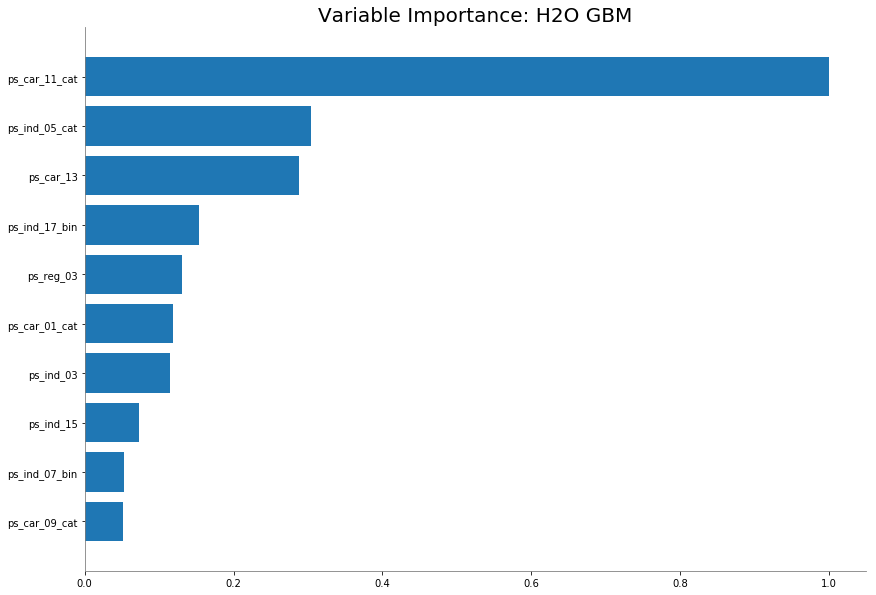

In [164]:
best_model.varimp_plot()

In [ ]:
performance_best_model = best_model.model_performance(test)

In [141]:
gbm_final_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                    ## more trees is better if the learning rate is small enough 
                    ## here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    ## smaller learning rate is better
                    ## since we have learning_rate_annealing, we can afford to start with a 
                    #bigger learning rate
                    learn_rate=0.05,
                    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
                    ## (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    ## score every 10 trees to make early stopping reproducible 
                    #(it depends on the scoring interval)
                    score_tree_interval = 10,
                    ## fix a random number generator seed for reproducibility
                    seed = 1234,
                    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    #5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4)
            
#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)
#Train grid search
final_grid.train(x=covtype_X, y=covtype_y,
           ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
           max_runtime_secs = 3600, 
           training_frame = train,
           validation_frame = valid)

print(final_grid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
     col_sample_rate col_sample_rate_change_per_level  \
0               0.63                              1.0   
1                0.5                             0.99   
2               0.57                              1.1   
3                0.5                             1.02   
4               0.47                             0.98   
5               0.33                             1.06   
6               0.44                             1.03   
7               0.27                             1.07   
8                0.6                              1.0   
9                0.4                             0.91   
10              0.91                             1.02   
11              0.66                             1.01   
12              0.55                             1.05   
13              0.42                             1.08   
14              0.67                             1.04   
15     

In [142]:
sorted_final_grid = final_grid.get_grid(sort_by='auc',decreasing=True)

print(sorted_final_grid)

     col_sample_rate col_sample_rate_change_per_level  \
0               0.47                             0.98   
1               0.63                              1.0   
2                0.5                             0.99   
3               0.57                              1.1   
4               0.27                             1.07   
5               0.33                             1.06   
6                0.5                             1.02   
7                0.6                              1.0   
8               0.44                             1.03   
9                0.4                             0.91   
10              0.91                             1.02   
11              0.66                             1.01   
12              0.42                             1.08   
13              0.55                             1.05   
14              0.67                             1.04   
15               0.5                             0.94   
16              0.75           

In [143]:
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(test)


0.63795926457345


In [144]:
print(performance_best_model.gini())

0.27591852914689996


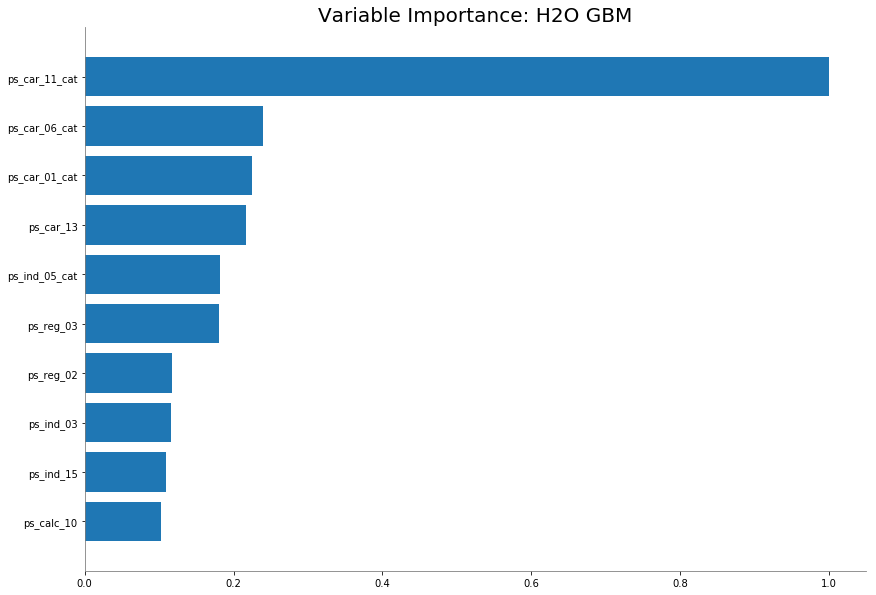

In [146]:
best_model.varimp_plot()

In [67]:
rf_v1 = H2ORandomForestEstimator(model_id="rf_covType_v1",
                                 ntrees=100,
                                 stopping_rounds=2,
                                 score_each_iteration=True,
                                 balance_classes=False,
                                 fold_assignment='stratified',
                                 nfolds=2,
                                 seed=41)

In [69]:
rf_v1.train(covtype_X, covtype_y, training_frame=train_bf)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [70]:
rf_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_covType_v1


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.035727915040486086
RMSE: 0.1890182928726373
LogLoss: 0.1658345839127855
Mean Per-Class Error: 0.44567585581007196
AUC: 0.5723792205184614
Gini: 0.1447584410369227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06620780904253572: 


,0,1,Error,Rate
0,478310.0,95208.0,0.166,(95208.0/573518.0)
1,16203.0,5491.0,0.7469,(16203.0/21694.0)
Total,494513.0,100699.0,0.1872,(111411.0/595212.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0662078,0.0897274,217.0
max f2,0.0232614,0.1704588,321.0
max f0point5,0.1091546,0.0694082,147.0
max accuracy,0.7983871,0.9635542,2.0
max precision,0.7983871,0.6666667,2.0
max recall,0.0001258,1.0,399.0
max specificity,0.8787879,0.9999983,0.0
max absolute_mcc,0.0662078,0.0435394,217.0
max min_per_class_accuracy,0.0276723,0.5532405,309.0
max mean_per_class_accuracy,0.0272901,0.5543241,310.0


Gains/Lift Table: Avg response rate:  3.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100015,0.4719221,27.4367106,27.4367106,1.0,1.0,0.2744077,0.2744077,2643.6710611,2643.6710611
,2,0.0200013,0.3489434,27.4321009,27.4344060,0.9998320,0.9999160,0.2743155,0.5487231,2643.2100949,2643.4405974
,3,0.0300011,0.2179535,27.3998333,27.4228824,0.9986559,0.9994960,0.2739928,0.8227160,2639.9833312,2642.2882398
,4,0.0400009,0.0876412,15.9586512,24.5569450,0.5816532,0.8950397,0.1595833,0.9822993,1495.8651233,2355.6944984
,5,0.0500007,0.0710138,0.8389586,19.8135071,0.0305780,0.7221532,0.0083894,0.9906887,-16.1041443,1881.3507088
,6,0.1000013,0.0499200,0.1272224,9.9703647,0.0046369,0.3633950,0.0063612,0.9970499,-87.2777593,897.0364748
,7,0.1500003,0.0419082,0.0331896,6.6580472,0.0012097,0.2426693,0.0016594,0.9987093,-96.6810431,565.8047222
,8,0.2000010,0.0368032,0.0129066,4.9967481,0.0004704,0.1821191,0.0006453,0.9993547,-98.7093379,399.6748117
,9,0.3000007,0.0299870,0.0036877,3.3324040,0.0001344,0.1214579,0.0003688,0.9997234,-99.6312332,233.2403955
,10,0.4000003,0.0252582,0.0027658,2.4999979,0.0001008,0.0911187,0.0002766,1.0,-99.7234249,149.9997900




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.035370003134324236
RMSE: 0.18806914455679388
LogLoss: 0.16004313777957466
Mean Per-Class Error: 0.4394338987801236
AUC: 0.583159998492616
Gini: 0.16631999698523203
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07134924832930077: 


,0,1,Error,Rate
0,502485.0,71033.0,0.1239,(71033.0/573518.0)
1,17198.0,4496.0,0.7928,(17198.0/21694.0)
Total,519683.0,75529.0,0.1482,(88231.0/595212.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0713492,0.0924884,192.0
max f2,0.0340252,0.1732797,290.0
max f0point5,0.0974425,0.0740940,145.0
max accuracy,0.4285714,0.9635558,12.0
max precision,0.7435897,0.6666667,2.0
max recall,0.0003238,1.0,399.0
max specificity,0.7948718,0.9999983,0.0
max absolute_mcc,0.0509010,0.0493122,240.0
max min_per_class_accuracy,0.0345700,0.5600713,288.0
max mean_per_class_accuracy,0.0422922,0.5605661,264.0


Gains/Lift Table: Avg response rate:  3.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100015,0.1475620,2.4150573,2.4150573,0.0880228,0.0880228,0.0241541,0.0241541,141.5057343,141.5057343
,2,0.0200013,0.1263708,1.8991809,2.1571408,0.0692204,0.0786224,0.0189914,0.0431456,89.9180909,115.7140792
,3,0.0300011,0.1140683,1.8715229,2.0619402,0.0682124,0.0751526,0.0187149,0.0618604,87.1522935,106.1940171
,4,0.0400009,0.1052456,1.6963558,1.9705479,0.0618280,0.0718216,0.0169632,0.0788236,69.6355764,97.0547908
,5,0.0500007,0.0986282,1.7101848,1.9184770,0.0623320,0.0699237,0.0171015,0.0959251,71.0184751,91.8477026
,6,0.1000013,0.0781444,1.4639796,1.6912283,0.0533584,0.0616411,0.0732000,0.1691251,46.3979586,69.1228306
,7,0.1500003,0.0664031,1.3155976,1.5660209,0.0479503,0.0570776,0.0657786,0.2349037,31.5597649,56.6020892
,8,0.2000010,0.0578855,1.2464108,1.4861177,0.0454286,0.0541653,0.0623214,0.2972250,24.6410831,48.6117706
,9,0.3000007,0.0460917,1.1842024,1.3854798,0.0431612,0.0504973,0.1184198,0.4156449,18.4202375,38.5479826
,10,0.4000003,0.0375780,0.9961313,1.2881431,0.0363065,0.0469496,0.0996128,0.5152577,-0.3868691,28.8143105



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid
accuracy,0.7984725,0.0412245,0.7401723,0.8567728
auc,0.5831988,0.0009886,0.5845969,0.5818008
err,0.2015275,0.0412245,0.2598278,0.1432272
err_count,59975.5,12267.949,77325.0,42626.0
f0point5,0.0671196,0.0020680,0.0641949,0.0700442
f1,0.0928192,0.0000181,0.0928448,0.0927936
f2,0.1525539,0.0106953,0.1676794,0.1374285
lift_top_group,2.3728876,0.0313486,2.417221,2.328554
logloss,0.1600431,0.0001734,0.1602883,0.1597980
max_per_class_error,0.7176348,0.0566137,0.637571,0.7976986


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-10-28 14:06:37,10 min 41.637 sec,0.0,nan,nan,nan,nan,nan
,2017-10-28 14:06:38,10 min 42.466 sec,1.0,0.2377130,1.5447877,0.4964069,17.2045147,0.9634081
,2017-10-28 14:06:39,10 min 43.327 sec,2.0,0.2333571,1.3633199,0.4929565,24.8160142,0.9634181
,2017-10-28 14:06:40,10 min 44.422 sec,3.0,0.2278500,1.1686886,0.4977934,26.5178998,0.9634382
,2017-10-28 14:06:41,10 min 45.673 sec,4.0,0.2229796,1.0047927,0.4988478,27.2016573,0.1984915
---,---,---,---,---,---,---,---,---
,2017-10-28 14:10:05,14 min 9.723 sec,66.0,0.1891661,0.1670362,0.5709584,27.4367106,0.1579891
,2017-10-28 14:10:10,14 min 15.197 sec,67.0,0.1891284,0.1667545,0.5714500,27.4367106,0.1713742
,2017-10-28 14:10:16,14 min 20.655 sec,68.0,0.1890865,0.1662899,0.5718321,27.4367106,0.1689028
,2017-10-28 14:10:21,14 min 26.229 sec,69.0,0.1890441,0.1659761,0.5722630,27.4367106,0.1694690



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
ps_car_11_cat_ps_ind_05_cat_ps_car_13_cut0,32760.5117188,1.0,0.0651410
ps_car_11_cat_ps_ind_05_cat_ps_car_13_cut,32051.1621094,0.9783474,0.0637306
ps_car_11_cat,28434.9042969,0.8679628,0.0565400
ps_reg_02_cut,25277.6835938,0.7715900,0.0502622
ps_car_01_cat,17443.4238281,0.5324527,0.0346845
---,---,---,---
ps_ind_14,905.8618774,0.0276510,0.0018012
ps_ind_12_bin,705.7554932,0.0215429,0.0014033
ps_ind_11_bin,213.5279694,0.0065178,0.0004246
ps_ind_13_bin,207.5963440,0.0063368,0.0004128



See the whole table with table.as_data_frame()


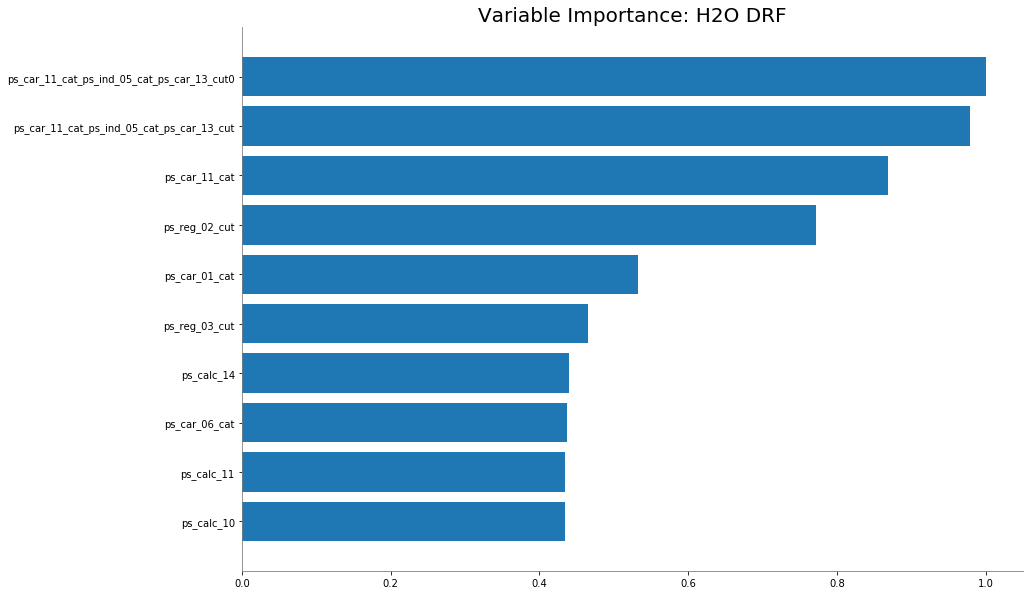

In [71]:
rf_v1.varimp_plot()

In [ ]:
rf_performance = rf_v1.model_performance(test_bf)

In [ ]:
rf_performance.gini()

In [ ]:
#adding features


In [ ]:
train_bf

In [ ]:
train_bf.rbind(test_bf)

In [72]:
gbm_opt_2 = H2OGradientBoostingEstimator(ntrees=100,
                                         learn_rate=0.05,
                                         col_sample_rate=0.1,
                                         max_depth=5,
                                         sample_rate=1,
                                         score_each_iteration=True,
                                         balance_classes=False,
                                         seed=41)
gbm_opt_2.train(x=covtype_X,
                y=covtype_y, 
                training_frame=train_bf)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [75]:
gbm_opt_2

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1509184042532_926


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.034190731478733895
RMSE: 0.18490735917949264
LogLoss: 0.14751502878928993
Mean Per-Class Error: 0.3628611924491827
AUC: 0.6918362094175966
Gini: 0.3836724188351932
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06695111928427477: 


,0,1,Error,Rate
0,540835.0,32683.0,0.057,(32683.0/573518.0)
1,16884.0,4810.0,0.7783,(16884.0/21694.0)
Total,557719.0,37493.0,0.0833,(49567.0/595212.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0669511,0.1625357,181.0
max f2,0.0454810,0.2354744,246.0
max f0point5,0.0990430,0.1720883,126.0
max accuracy,0.1910196,0.9637827,61.0
max precision,0.8004071,1.0,0.0
max recall,0.0134061,1.0,396.0
max specificity,0.8004071,1.0,0.0
max absolute_mcc,0.0623449,0.1274862,192.0
max min_per_class_accuracy,0.0362808,0.6345072,284.0
max mean_per_class_accuracy,0.0379772,0.6371388,275.0


Gains/Lift Table: Avg response rate:  3.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100015,0.1083329,7.0515987,7.0515987,0.2570133,0.2570133,0.0705264,0.0705264,605.1598729,605.1598729
,2,0.0200013,0.0911830,3.7199976,5.3859381,0.1355847,0.1963041,0.0371992,0.1077256,271.9997558,438.5938068
,3,0.0300011,0.0820794,3.1944960,4.6554983,0.1164315,0.1696814,0.0319443,0.1396700,219.4496044,365.5498300
,4,0.0400009,0.0759525,2.7750168,4.1853977,0.1011425,0.1525474,0.0277496,0.1674196,177.5016765,318.5397662
,5,0.0500007,0.0713920,2.4892177,3.8461731,0.0907258,0.1401835,0.0248917,0.1923112,148.9217697,284.6173068
,6,0.1000013,0.0578718,2.0539965,2.9500848,0.0748631,0.1075233,0.1027012,0.2950124,105.3996547,195.0084807
,7,0.1500003,0.0506747,1.6198354,2.5066783,0.0590390,0.0913622,0.0809901,0.3760026,61.9835368,150.6678261
,8,0.2000010,0.0459415,1.3939151,2.2284851,0.0508047,0.0812228,0.0696967,0.4456993,39.3915072,122.8485126
,9,0.3000007,0.0394501,1.1689907,1.8753223,0.0426068,0.0683508,0.1168987,0.5625980,16.8990745,87.5322310
,10,0.4000003,0.0350467,0.9905998,1.6541426,0.0361049,0.0602894,0.0990596,0.6616576,-0.9400193,65.4142613



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-10-28 14:19:06,0.016 sec,0.0,0.1874009,0.1564850,0.5,1.0,0.9635525
,2017-10-28 14:19:06,0.308 sec,1.0,0.1873405,0.1561712,0.6014939,2.5729538,0.1112914
,2017-10-28 14:19:06,0.499 sec,2.0,0.1872755,0.1558512,0.6236079,3.3130439,0.1426668
,2017-10-28 14:19:06,0.742 sec,3.0,0.1872190,0.1555738,0.6284878,3.4003794,0.1278015
,2017-10-28 14:19:07,1.306 sec,4.0,0.1871492,0.1552514,0.6335828,3.8324294,0.1231091
---,---,---,---,---,---,---,---,---
,2017-10-28 14:21:37,2 min 30.798 sec,96.0,0.1849611,0.1476600,0.6905871,6.9686387,0.0878023
,2017-10-28 14:21:39,2 min 33.389 sec,97.0,0.1849511,0.1476321,0.6908430,6.9455943,0.0874428
,2017-10-28 14:21:42,2 min 35.994 sec,98.0,0.1849267,0.1475720,0.6913197,6.9962921,0.0879502
,2017-10-28 14:21:44,2 min 38.642 sec,99.0,0.1849147,0.1475380,0.6916333,7.0331632,0.0858719



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
ps_car_11_cat_ps_ind_05_cat_ps_car_13_cut,1087.9299316,1.0,0.2332196
ps_car_11_cat_ps_ind_05_cat_ps_car_13_cut0,1073.5120850,0.9867474,0.2301289
ps_car_11_cat,367.7597351,0.3380362,0.0788367
ps_ind_17_bin,206.6352692,0.1899344,0.0442964
ps_reg_02_cut,153.0672760,0.1406959,0.0328130
---,---,---,---
ps_calc_15_bin,0.9678453,0.0008896,0.0002075
ps_ind_12_bin,0.7544561,0.0006935,0.0001617
ps_ind_13_bin,0.3666202,0.0003370,0.0000786
ps_ind_10_bin,0.2568902,0.0002361,0.0000551



See the whole table with table.as_data_frame()


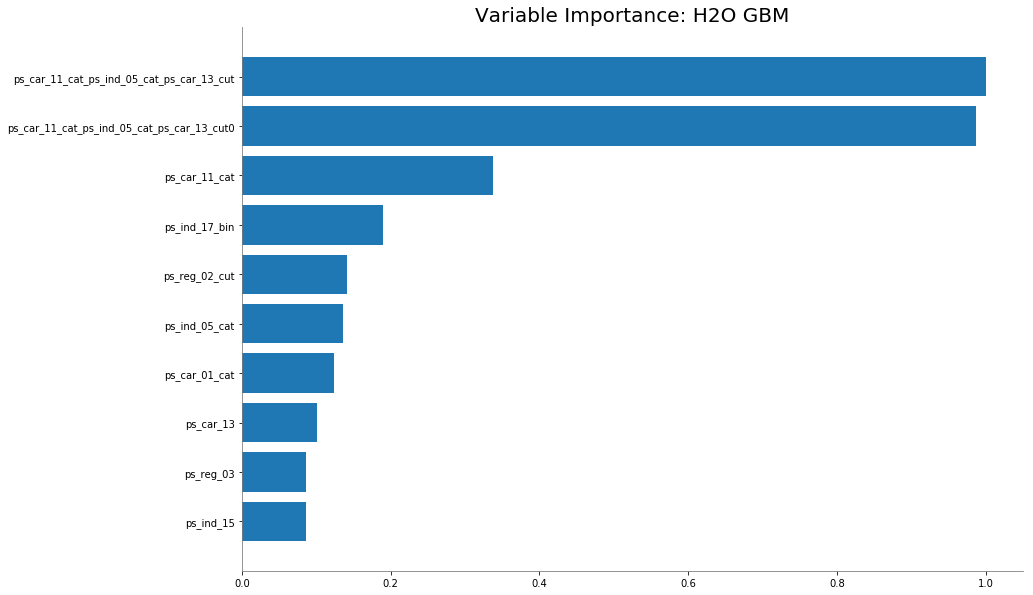

In [76]:
gbm_opt_2.varimp_plot()

In [27]:
gbm_performance = gbm_opt_2.model_performance(test_bf)

In [ ]:
gbm_opt_1 = H2OGradientBoostingEstimator(ntrees=100,
                                         learn_rate=0.05,
                                         col_sample_rate=0.1,
                                         max_depth=5,
                                         sample_rate=1,
                                         score_each_iteration=True,
                                         balance_classes=False,
                                         fold_assignment='stratified',
                                         nfolds=5,
                                         seed=41)
gbm_opt_1.train(x=covtype_X,
                y=covtype_y, 
                training_frame=covtype_df)

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [ ]:
p = gbm_opt_2.predict(test_data=test_bf)

In [ ]:
sub['target'] = p['p1'].as_data_frame(True).values

In [ ]:
filename = 'GB_model_'+str(dt.datetime.now()).replace(' ','_').replace(':','').replace('.','')
sub.id = sub.id.astype('Int32')
sub.to_csv('../output/'+filename+'.csv', index=False)

In [ ]:
[x[0] for x in gbm_opt_1.varimp()][:10]

In [ ]:
gbm_opt_1.varimp_plot()

In [ ]:
gbm_opt_1.gini()

In [ ]:
gbm_opt_1.gini()

In [ ]:
gbm_opt_1.auc()

In [ ]:
gbm_opt_1.auc()

In [ ]:
gbm_opt_1.cross_validation_metrics_summary

In [ ]:
gbm_opt_1.cross_validation_metrics_summary

In [ ]:
gbm_opt_2.varimp_plot()

In [ ]:
gbm_v1 = H2OGradientBoostingEstimator(ntrees=100,
                                     score_each_iteration=True,
                                     balance_classes=False,
                                     stopping_rounds=2,
                                     fold_assignment='stratified',
                                     stopping_metric = 'auc',
                                     nfolds=2,
                                     seed=41)

In [ ]:
gbm_params = {  'learn_rate': [0.01, 0.05,0.025,0.5,0.1], 
                'max_depth': [3, 5,7,11, 9],
                'sample_rate': [0.8,0.85,0.9,0.095, 1.0],
                'col_sample_rate': [0.1,0.15,0.2, 0.25,0.3]}

search_criteria = {'strategy': 'RandomDiscrete', "max_runtime_secs": 60*60}

gbm_grid1 = H2OGridSearch(model=gbm_v1,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params,
                          search_criteria =search_criteria )

gbm_grid1.train(x=covtype_X,
                y=covtype_y, 
                training_frame=train_bf, 
                seed=1)


In [ ]:
gbm_grid1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)

In [ ]:
gbm_grid1

In [ ]:
gbm_grid1

In [ ]:
gbm_grid1

In [ ]:
#col_sample_rate learn_rate max_depth sample_rate          
#              0.2       0.01         7         1.0  

In [ ]:
best_gbm_model = gbm_grid1.models[0]

In [ ]:
best_gbm_model.varimp_plot()

In [ ]:
gbm_perf = best_gbm_model.model_performance(test)
print (gbm_perf.gini())
print (gbm_perf.auc())

In [ ]:
best_gbm_model = gbm_grid1.models[0]

In [ ]:
gbm_perf = best_gbm_model.model_performance(test)
print (gbm_perf.auc())

In [ ]:
gbm_perf

In [ ]:
gbm_perf.gini()

In [ ]:
gbm_v1.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

In [ ]:
gbm_v1

In [ ]:
gbm_v1

In [ ]:
gbm_v1.varimp_plot()

In [ ]:
performance = gbm_v1.model_performance(test_data=test)

In [ ]:
performance

In [ ]:
performance

In [ ]:
gbm_v1

In [5]:
h2o.shutdown(prompt=False)

[WARNING] in <ipython-input-5-06c455af4589> line 1:
    >>> h2o.shutdown(prompt=False)
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.


H2OConnectionError: Not connected to a cluster. Did you run `h2o.connect()`?